In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42) 
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)


[[0.00026602]
 [0.00035539]] [3.41199385]
[[0.00026602 0.00035539]] [3.41199385]
(100, 2) (100, 1)


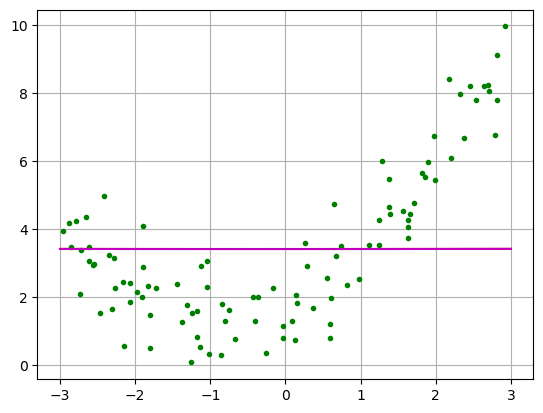

In [6]:
from regression import LinearRegression
from sklearn.linear_model import Ridge as SKRidge
from sklearn.linear_model import LinearRegression as SKLinearRegression 

class Ridge():
  def __init__(self, alpha) -> None:
    self.alpha = alpha

  def __add_bias(self, X):
    return np.c_[np.ones((X.T.shape[-1],1)), X]
  
  def fit(self, X, y):
    X_b = self.__add_bias(X)
    A = np.identity(X_b.shape[1])
    A[0, 0] = 0
    self.theta = np.linalg.inv(X_b.T @ X_b  + self.alpha * A) @ X_b.T @ y
    self.intercept_ = self.theta[0]
    self.coef_ = self.theta[1:]

    
  def predict(self, X):
    return self.__add_bias(X) @ self.theta

X_poly = np.c_[X, np.power(X, 2)]
X_test = np.linspace(-3, 3, m).reshape(m, 1)

X_poly_test = np.c_[X_test, np.power(X_test, 2)]

plt.plot(X, y, "g.", label="Predictions")

alpha = 1000000.0

lr = Ridge(alpha=alpha)
lr.fit(X_poly, y)
print(lr.coef_, lr.intercept_)

y_pred = lr.predict(X_poly_test)

plt.plot(X_test, y_pred, "r-")


lr2 = SKRidge(alpha=alpha, solver="cholesky")
lr2.fit(X_poly, y)
print(lr2.coef_, lr2.intercept_)

y_pred_reg = lr2.predict(X_poly_test)
print(X_poly.shape, y_pred.shape)
plt.plot(X_test, y_pred_reg, "m-")

# plt.scatter(X, y)
plt.grid(True)
plt.show()

[[0.39181762]
 [0.49347281]] [3.41315212]
[-0.00671837  0.03801852] [1.05255967]
(100, 2) (100,)


c:\Users\Vadim\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Vadim\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


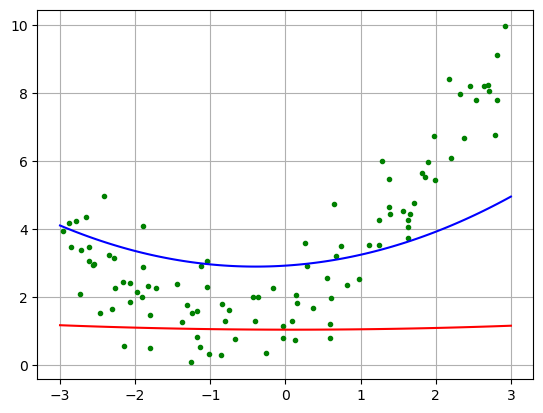

In [105]:
from sklearn.linear_model import SGDRegressor
#from regression import SGDRegression
from utils import StandardScaler


class SGDRegression():
    def __init__(self, n_iter, eta0, seed = None, penalty="", alpha = None, r=None, lr0=None, lr1=None) -> None:
        self.n_iter = n_iter
        self.penalty = penalty
        self.lr0 = lr0
        self.lr1 = lr1
        self.eta0 = eta0
        assert not ((penalty == "") and (alpha != None)), "Alpha must be none, when penalty is empty"
        self.alpha = alpha
        if (penalty == "elastic") and (r == None):
           raise Exception("r value for elastic net is None")
        if (penalty == "elastic") and ((r >= 1) or (r < 0)):
           raise Exception("r must be (r <= 1)  (r > 0)")
        self.r = r

        if seed is not None:
            self.rng = np.random.default_rng(seed=seed)


    def __add_bias(self, X):
        return np.c_[np.ones((X.T.shape[-1],1)), X]
  
    def learning_schedule(self, t):
        return self.lr0 / (t + self.lr1)
    
    def learning_schedule_optimal(self, t):
        #optimal_init = 1.0 / (self.eta0 * m)
        return 1 / (t + self.eta0)

    def fit(self, X:np.ndarray, y):
        X_b = self.__add_bias(X)
        #X_b = X.copy()
       
        self.theta = self.rng.standard_normal((X_b.shape[1], 1))

        # self.coef_ = self.rng.standard_normal((X_b.shape[1] - 1, 1))
        # self.intercept_ = self.rng.standard_normal((1, 1))

        m = len(X_b)

        for epoch in range(self.n_iter):
            for iteration in range(m):
                sample_index =  self.rng.integers(m)
                Xi = X_b[sample_index: sample_index+1]
                yi = y[sample_index: sample_index+1]

                if self.penalty == "l1":
                    l1 = self.alpha * np.sign(self.theta)
                    l1[0] = 0
                    gradient = 2 * Xi.T @ (Xi @ self.theta - yi) + l1

                elif self.penalty == "l2":
                    l2 = 2 * self.alpha * self.theta
                    l2[0] = 0
                    gradient = 2 * Xi.T @ (Xi @ self.theta - yi) + l2

                elif self.penalty == "elastic":
                    l1 = self.alpha * np.sign(self.theta)
                    l1[0] = 0
                    l2 = 2 * self.alpha * self.theta
                    l2[0] = 0

                    gradient = 2 * Xi.T @ (Xi @ self.theta - yi) + self.r * l1 + (1-self.r) * l2

                eta = self.learning_schedule_optimal(epoch * m + iteration + 1)

                self.theta -= eta * gradient


        self.intercept_ = self.theta[0]
        self.coef_ = self.theta[1:]

    def predict(self, X):
        return self.__add_bias(X) @ self.theta

    
    
X_poly = np.c_[X, np.power(X, 2)]
X_test = np.linspace(-3, 3, m).reshape(m, 1)

std_scaler = StandardScaler()

X_poly_scaled = std_scaler.fit_transform(X_poly)


X_poly_test = np.c_[X_test, np.power(X_test, 2)]
X_poly_test_scaled = std_scaler.fit_transform(X_poly_test)


plt.plot(X, y, "g.", label="Predictions")

sgd = SGDRegression(n_iter=14, eta0=0.01, seed=42, penalty="elastic", alpha=2, r=0.1)
sgd.fit(X_poly_scaled, y)
print(sgd.coef_, sgd.intercept_)

y_pred = sgd.predict(X_poly_test_scaled)

plt.plot(X_test, y_pred, "b-")


lr2 =  SGDRegressor(max_iter=1, eta0=0.01, random_state=42, penalty="l2",  alpha=70, learning_rate="optimal")
lr2.fit(X_poly_scaled, y)
print(lr2.coef_, lr2.intercept_)  

y_pred_reg = lr2.predict(X_poly_test_scaled)
print(X_poly_scaled.shape, y_pred_reg.shape)
plt.plot(X_test, y_pred_reg, "r-")



#plt.axis([-5, 5, -5, 10])

# plt.scatter(X, y)
plt.grid(True)
plt.show()


In [ ]:
def sigmoid(t):
    return 1/(1 + np.exp(-t))

class LogisticRegression():
    def __init__(self) -> None:
        pass
    
    def learning_schedule_optimal(self, t):
        return 1 / (t + self.eta0)
    
    def __add_bias(self, X):
        return np.c_[np.ones((X.T.shape[-1],1)), X]
  

    def fit(self, X, y):

        X_b = self.__add_bias(X)
        #X_b = X.copy()
       
        self.theta = self.rng.standard_normal((X_b.shape[1], 1))

        # self.coef_ = self.rng.standard_normal((X_b.shape[1] - 1, 1))
        # self.intercept_ = self.rng.standard_normal((1, 1))

        m = len(X_b)

        for epoch in range(self.n_iter):
            for iteration in range(m):
                sample_index =  self.rng.integers(m)
                Xi = X_b[sample_index: sample_index+1]
                yi = y[sample_index: sample_index+1]

                gradient = 2/m * Xi.T @ (sigmoid(Xi @ self.theta) - yi)

                eta = self.learning_schedule_optimal(epoch * m + iteration + 1)

                self.theta -= eta * gradient


        self.intercept_ = self.theta[0]
        self.coef_ = self.theta[1:]


    def predict(self, X):
        return sigmoid(self.__add_bias(X) @ self.theta)